## Accessing remote archives/data repositories and querying for new data containing our sources
In this example notebook, we will use the `QueryTool` class to retrieve and add new images to our locally stored images, expanding the arsenal of our photometry.

Firstly, in case this repository is cloned and not pip installed...

In [1]:
from sys import path
import os, glob
# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Navigate up to the project root
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))

# Add the project root to sys.path
if project_root not in path:
    path.append(project_root)

Now import the necessary modules, classes and functions for this notebook

In [2]:
from quest.lib_data import DataTool
from quest.lib_query import QueryTool, default_online_archive_config
from quest.lib_plot import plot_all_stamps
import warnings
from astropy.io import fits
from astropy.wcs import FITSFixedWarning
import astropy.units as u

(Duplicate from the first notebook) Here is an example configuration that feeds in to the initialisation and use of the classes. Some directories are created if not already existing, but they should already match the directory structure of the repository. Feel free to swap out values to test with your own data and input source lists.

In [3]:
# --- Global Configuration ---
# Working path, input source list, output database file
data_dir = '../demo/data'
src_list_file = f'{data_dir}/example_sources.lis'
# Input source list can be parsed as you wish later, but it must contain:
#   - Source (long) name... typically the J2000 coordinate in hms dms
#   - Source (short) name... this is used for display/annotation on plots
#   - Source RA and Dec... can be in whatever format you wish, but it will have to be made into a SkyCoord instance
db_save_path = f'{data_dir}/source_data.db'

# Output directories for figures and data
output_fig_dir = '../demo/figures'
output_data_dir = '../demo/output'
if not os.path.exists(output_fig_dir):
    os.mkdir(output_fig_dir)
if not os.path.exists(output_data_dir):
    os.mkdir(output_data_dir)

# Optional to section off your data into directories in some fashion (e.g. wavelength domain).
# These must exist in the working path (e.g. `./demo/data`, creating them if not).
data_sub_dirs = [f'{data_dir}/Optical', f'{data_dir}/IR', f'{data_dir}/Radio']
for search_dir in data_sub_dirs:
    if not os.path.exists(search_dir):
        os.mkdir(search_dir)

# You can define the **PHOTOMETRY** search paths here.
# Searches are made at the level of the defined paths below recursively (e.g. /my/path/**/*.fits)
data_dir_list = [f'{data_dir}/Optical', f'{data_dir}/IR']
# Similar for the **CONTOUR** search paths here, which we use the radio for (only tested with radio currently)
data_dir_radio = [f'{data_dir}/Radio']

# You can define the paths to ignore when searching here
# (i.e. if a searched path CONTAINS any of the strings in the ignore_paths list).
ignore_paths = ['dud_cutouts', f'{data_dir}/IR/unWISE', f'{data_dir}/IR/2MASS', f'{data_dir}/Radio/TGSS']

# Filter out certain warnings
warnings.filterwarnings('ignore', category=FITSFixedWarning)
warnings.filterwarnings('ignore', category=fits.verify.VerifyWarning)

Back to our main workflow from earlier! This time we are initialising from the checkpoint we saved in the first notebook, containing some of our local data. We don't need to add our sources again (but could add new ones at any point!) and we don't need to scan the local directories until we download our new data.

In [4]:
##### Main Workflow #####

# 1. Initialize or load the data database
try:
    db = DataTool()
    db.load_from_file(filepath=db_save_path)
except (FileNotFoundError, EOFError):
    print("No existing database found or file is empty, initializing a new one.")
    db = DataTool(search_directories=data_dir_list)
    db.set_ignored_filepaths(ignore_paths=ignore_paths)

Database loaded from ../demo/data/source_data.db. Contains 2 sources and 4 checked images.


Now we use the `QueryTool` (and some included pre-defined query config, which can be expanded upon yourself using some of the templates), to retrieve some additional data from VISTA, DECaLS and Spitzer for our sources. We'll also grab some radio data while we're at it!

After querying and downloading, we'll re-scan the local directories to add them to the `DataTool` and associated with our `SourceEntry` instances. Finally, we'll save a new checkpoint of our `DataTool`.

In [ ]:
# 3.1 Optionally, query online archives for any that are manually specified here
query = QueryTool(data_dir)
query.set_online_archives(default_online_archive_config)
for source in db.sources:
    print(f"Querying SEIP for source {source.source_name}...")
    query.query_online_archive('SEIP', coord=source.radio_coord, bands=None, cutout_size=180*u.arcsec)
    print(f"Querying DECaLS for source {source.source_name}...")
    query.query_online_archive('DECaLS', coord=source.radio_coord, bands=None, cutout_size=180*u.arcsec)
    print(f"Querying VISTA science archive for source {source.source_name}...")
    query.query_online_archive('VISTA', coord=source.radio_coord, bands=None, cutout_size=180*u.arcsec)
    print(f"Querying CADC for source {source.source_name}...")
    query.query_online_archive('VLASS', source.radio_coord, query_radius=10*u.arcsec, cutout_size=3*u.arcmin)
    pass
db.scan_local_directories()   # Re-scan to include any newly downloaded images

db.save_to_file(f'{data_dir}/source_data_expanded.db')

### End of querying and downloading more data
That should have been pretty simple. You can try exploring the data-driven properties similar to the first notebook now that we have more data.

In [8]:
print(db.sources[0])

SourceEntry(self.source_name='TN J0924-2201'
        	self.short_label=' J0924'
        	self.radio_coord=<SkyCoord (ICRS): (ra, dec) in deg
    (141.083, -22.028194)>
        	self.host_coord=<SkyCoord (ICRS): (ra, dec) in deg
    (141.083, -22.028194)>
        	self.best_data={'z': DataEntry(self.filepath='../demo/data/Optical/DECaLS/09h24m19.92s-22d01m41.50s_z_180.0arcsec_cutout.fits'
        		self.astronomy_method='photometric'
        		self.instrument='DECaLS'
        		self.band='z'
        		self.wavelength=<Quantity 0.926 um>
        		self.rms=9.8251164e-08
        		self.pix_res=<Quantity 7.27777778e-05 deg>)
			, 'Ks': DataEntry(self.filepath='../demo/data/IR/VISTA/09h24m19.92s-22d01m41.50s_VHS_Ks_180.0arcsec_cutout.fits'
        		self.astronomy_method='photometric'
        		self.instrument='VIRCAM'
        		self.band='Ks'
        		self.wavelength=<Quantity 2.146 um>
        		self.rms=0.0007193797960999267
        		self.pix_res=<Quantity 9.48188594e-05 deg>)
			, 'MI

As a new example of an included functionality, we'll plot stamps for all the retrieved data for each source, with a customisable cutout size and sigma-thresholded normalisation stretch.

Re-aligning WCS to celestial north and target coord due to: ["Outdated coordinate frame 'FK5' detected (ICRS is preferred)."]
Re-aligning WCS to celestial north and target coord due to: ["Outdated coordinate frame 'FK5' detected (ICRS is preferred)."]


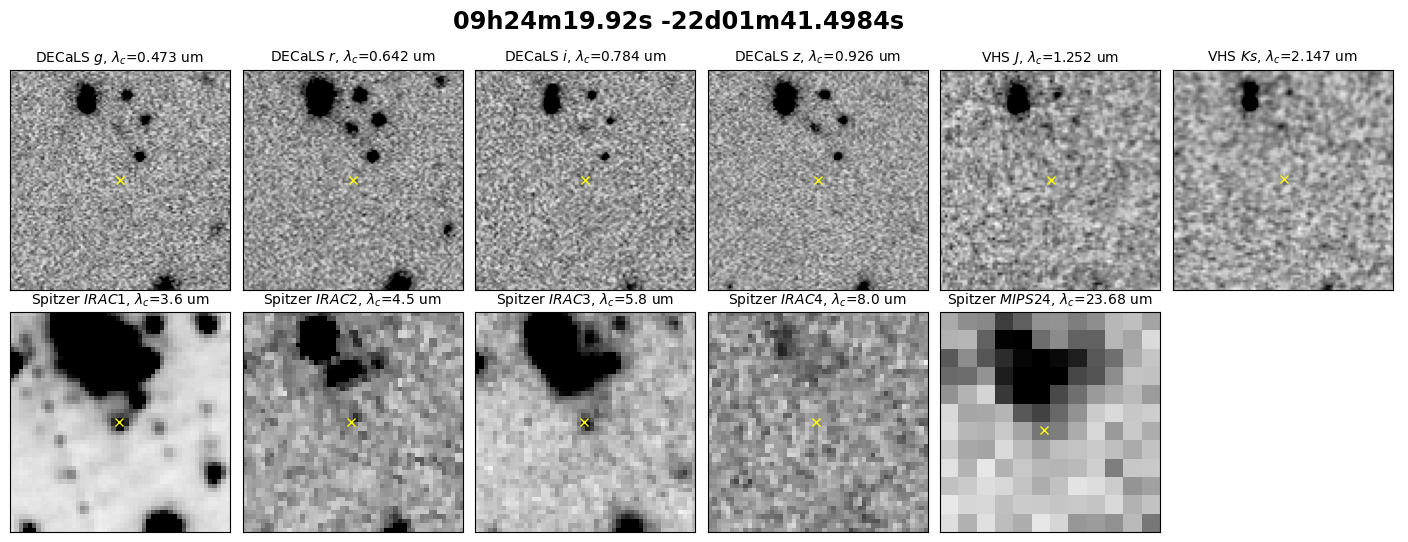

Re-aligning WCS to celestial north and target coord due to: ["Outdated coordinate frame 'FK5' detected (ICRS is preferred)."]
Re-aligning WCS to celestial north and target coord due to: ["Outdated coordinate frame 'FK5' detected (ICRS is preferred)."]
Re-aligning WCS to celestial north and target coord due to: ["Outdated coordinate frame 'FK5' detected (ICRS is preferred)."]
Re-aligning WCS to celestial north and target coord due to: ["Outdated coordinate frame 'FK5' detected (ICRS is preferred)."]
Re-aligning WCS to celestial north and target coord due to: ["Outdated coordinate frame 'FK5' detected (ICRS is preferred)."]


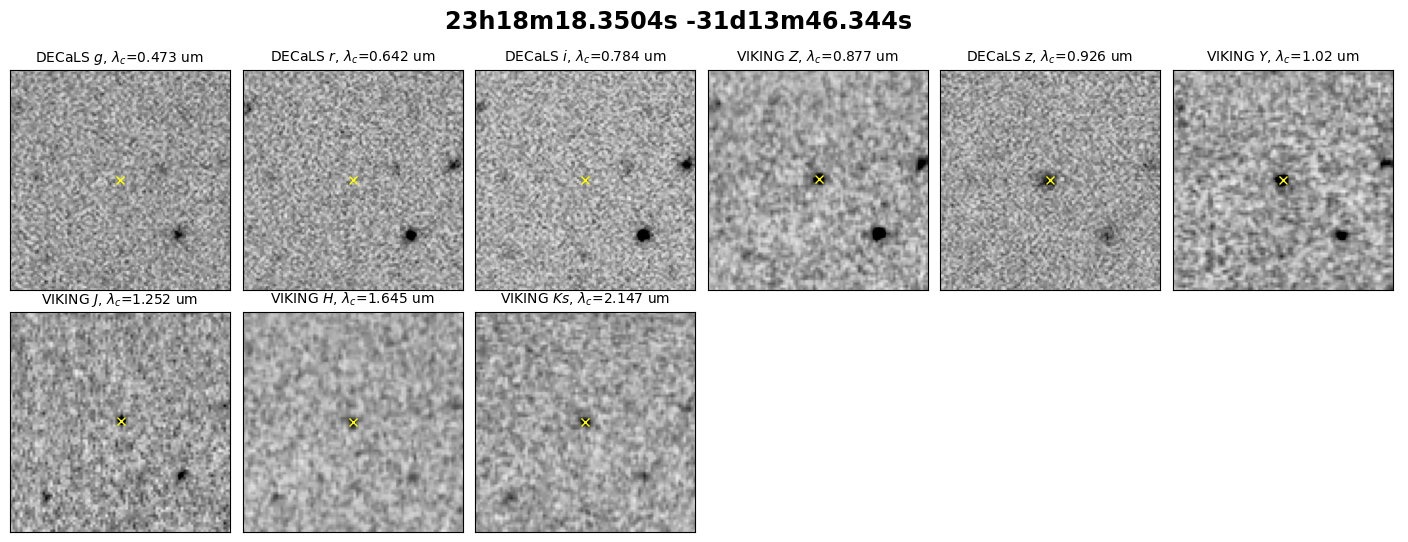

In [9]:
# This will plot all the associated data, regardless of if it is in the 'best_data' for the source
# at the particular wavelength band. The yellow cross shows the input/initial coordinate
# (radio_coord property of SourceEntry).
for se in db.sources:
    plot_all_stamps(se, cutout_size=30*u.arcsec, sigma_clip_norm=5)